### Create a confusion matrix

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import argparse
import wandb
from sklearn.metrics import confusion_matrix
#from matplotlib.pyplot import plt

plt.ion()   # interactive mode

data_dir = "/home/jonathan/Videos/Patient_Images_Original/new_dataset_11_try_Sa_Feb_2020"


In [2]:
wandb.init(project= "pytorch_quick_run")

W&B Run: https://app.wandb.ai/schopfej/pytorch_quick_run/runs/w0z1ofwr

In [3]:
wandb.init(project= "pytorch_quick_run_resnet152")
#parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
#parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
#parser.add_argument('--epo', default=2, type=int, help='epochs')
#parser.add_argument('--mom', default=0.8, type=float, help='momentum')
#parser.add_argument('--batch', default=4, type=int, help='batch size')
#parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')
#parser.add_argument('--path', default="/home/jonathan/Documents/try_error_grouping_eye/test_pers_6/", type=str, help='PATH to Folder Train and Val')


epo = 5
lr = 0.0001 
mom = 0.9
batch = 50 
epo = 20 


#args = parser.parse_args()
config = wandb.config
config.batch_size = batch
config.lr = lr
config.momentum = mom
config.epochs = epo 


In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(225),
        transforms.Resize(224),
        transforms.ColorJitter(brightness=0.8,saturation=0.1),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        #AddGaussianNoise(0., 0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #AddGaussianNoise(0., 0.3),
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(230),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [6]:
#data_dir = args.path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

######################################################################
# Visualize a few images
# ^^^^^^^^^^^^^^^^^^^^^^
# Let's visualize a few training images so as to understand the data
# augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



In [7]:
class_names

['non_radius', 'radius']

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    confusion_matrix = torch.zeros(2, 2)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #if phase == 'train': 
                    if phase == 'val':
                        for l, p in zip(labels.view(-1), preds.view(-1)):
                            #lab = ['blink' , 'non_radius', 'radius'] 
                            #cm = confusion_matrix(y_test, pred, labels) 
                            confusion_matrix[l.long(), p.long()] += 1
 
                            #confusion_matrix[l.long(), p.long()] += 1
                        

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()




            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                wandb.log({"Train Acc": epoch_acc,
                           "Train Loss": epoch_loss})
            else:
                wandb.log({
                    "Test Acc": epoch_acc,
                           "Test Loss": epoch_loss})



            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'checkpoint.pth')
		#wandb.log({ "Example": visualize_model(model_conv)})


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights

    wandb.log({
               '{} Accuracy:'.format(
                phase): epoch_acc,
               '{} Loss:'.format(
                phase): epoch_loss})
    model.load_state_dict(best_model_wts)
    cm = confusion_matrix.detach().cpu().numpy()
    print(cm) 
    lab = ['non_radius', 'radius'] 
    normed_cm = (cm.T / cm.astype(np.float).sum(axis=1)).T
    fig = plt.figure() 

    ax = fig.add_subplot(111) 
    cax = ax.matshow(normed_cm) 
    plt.title('Confusion matrix of the classifier') 
    fig.colorbar(cax) 
    ax.set_xticklabels([''] + lab) 
    ax.set_yticklabels([''] + lab) 
    plt.xlabel('Predicted') 
    plt.ylabel('True') 
    wandb.log({"examples": [wandb.Image(plt.show(), caption="Label")]})
    plt.show()
                   
    print(normed_cm)
    return model



In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



Epoch 0/2
----------
train Loss: 0.5161 Acc: 0.7557
val Loss: 0.4580 Acc: 0.8047

Epoch 1/2
----------
train Loss: 0.4614 Acc: 0.7893
val Loss: 0.4478 Acc: 0.8061

Epoch 2/2
----------
train Loss: 0.4457 Acc: 0.8012
val Loss: 0.4318 Acc: 0.8243

Training complete in 20m 18s
Best val Acc: 0.824278
[[5187. 1638.]
 [ 847. 5525.]]


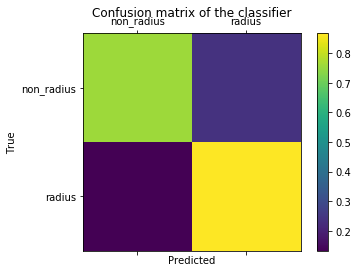

[[0.76      0.24     ]
 [0.1329253 0.8670747]]


In [12]:
model_conv = torchvision.models.resnet101(pretrained=True)

#model = models.resnet101(pretrained=True)
#num_ftrs = model_conv.fc.in_features
num_ftrs = model_conv.fc.in_features

model_conv.fc = nn.Sequential(
    nn.Dropout(0.2))

#every parameter has an attribute called requires_grad which is by default True. True means it will be backpropagrated
# and hence to freeze a layer you need to set requires_grad to False for all parameters of a layer. This can be done like this

#model = models.resnet50(pretrained=True)
#num_ftrs = model_conv.fc.in_features

ct = 0
for child in model_conv.children():
	ct += 1
	if ct < 150:
    		for param in child.parameters():
        		param.requires_grad = False


#model_conv = torchvision.models.resnet101(pretrained=True)
#for param in model_conv.parameters():
#    param.requires_grad = False


'''
for name, child in model.named_children():
   if name in ['layer3', 'layer4']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False
'''

#This freezes layers 1-6 in the total 10 layers of Resnet50. Hope this helps!

#optimizer_conv = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0006, momentum=0.9)

# Parameters of newly constructed modules have requires_grad=True by default

model_conv.fc = nn.Linear(num_ftrs,2)
#model_conv.fc = nn.Sequential(
#    nn.Dropout(0.4))

model_conv = model_conv.to(device)

#model = models.resnet18(pretrained=True)
#############################################################################

######################## Adding dropout #####################################
#############################################################################

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=lr, momentum=mom)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=15, gamma=0.01)


######################################################################
# Train and evaluate


model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=3)


In [13]:
import matplotlib.pyplot as plt
import torchvision.models as models

from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

In [14]:
backprop = Backprop(model_conv.cpu())

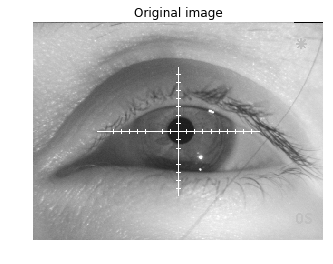

In [15]:
image = load_image("/home/jonathan/Documents/try_error_grouping_eye/test_pers_6/val/radius/Serife_Kucur_Ergunay_left_eye__stimulus_coord__0_0_hour_min_sec161149_frame_002615.png")

plt.imshow(image)
plt.title('Original image')
plt.axis('off');

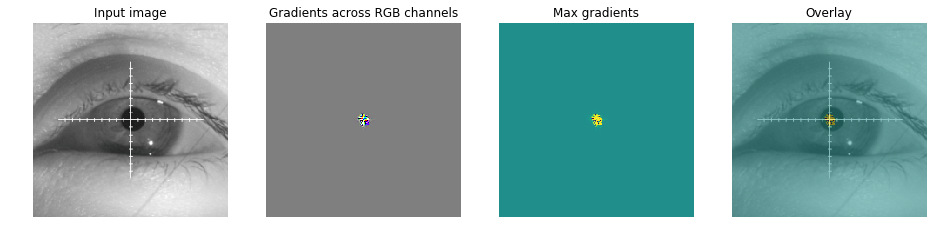

In [16]:
# Transform the input image to a tensor

owl = apply_transforms(image)

# Set a target class from ImageNet task: 24 in case of great gray owl

target_class = 1

# Ready to roll!

# Transform the input image to a tensor
backprop.visualize(owl, target_class, guided=True)

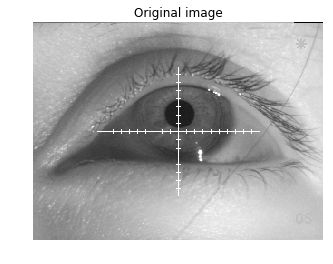

In [17]:
image = load_image("/home/jonathan/Documents/try_error_grouping_eye/test_pers_6/val/non_radius/Serife_Kucur_Ergunay_left_eye__stimulus_coord__0_12_hour_min_sec161043_frame_001954.png")

plt.imshow(image)
plt.title('Original image')
plt.axis('off');

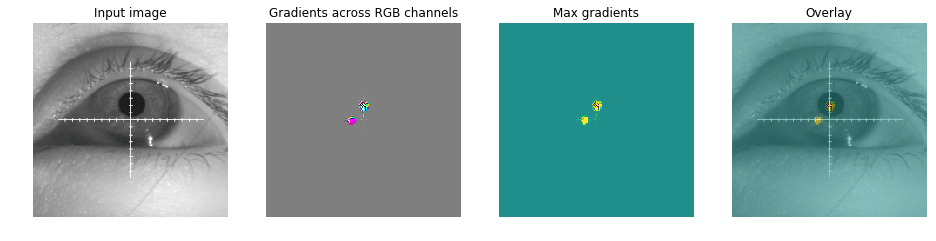

In [18]:
# Transform the input image to a tensor

owl = apply_transforms(image)

# Set a target class from ImageNet task: 24 in case of great gray owl

target_class = 25

# Ready to roll!

# Transform the input image to a tensor
backprop.visualize(owl, target_class, guided=True)

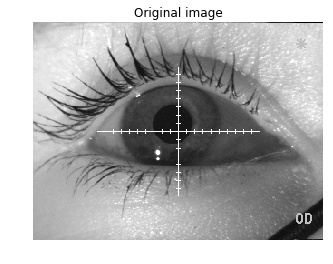

In [36]:
image = load_image("/home/jonathan/Videos/Patient_Images_Original/gazeFeed_Valeriia_Volodkina/gazeFeed/Valeriia_Volodkina_adjusted_right_eye__stimulus_coord__4_8_hour_min_sec153316/frame_001579.png")

plt.imshow(image)
plt.title('Original image')
plt.axis('off');

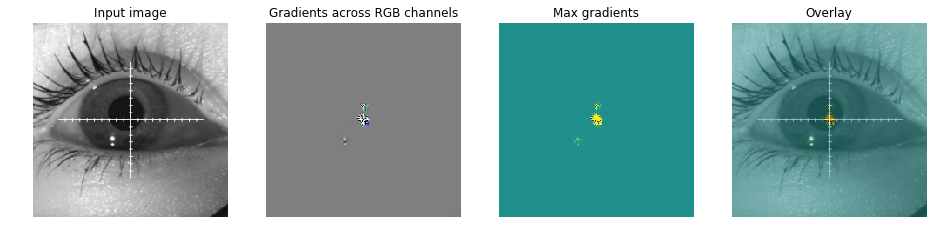

In [39]:
# Transform the input image to a tensor

owl = apply_transforms(image)

# Set a target class from ImageNet task: 24 in case of great gray owl

target_class = 2

# Ready to roll!

# Transform the input image to a tensor
backprop.visualize(owl, target_class, guided=True)

### One of the model when non-radius prediction works better

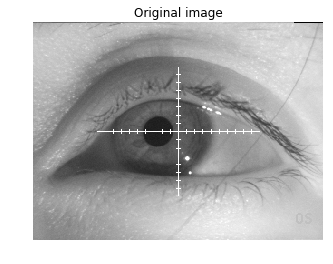

In [24]:
image = load_image("/home/jonathan/Documents/try_error_grouping_eye/test_pers_6/val/non_radius/Serife_Kucur_Ergunay_left_eye__stimulus_coord__12_0_hour_min_sec160957_frame_001488.png")

plt.imshow(image)
plt.title('Original image')
plt.axis('off');

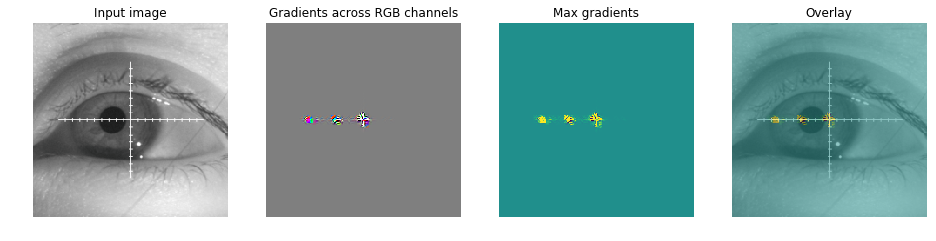

In [25]:
# Transform the input image to a tensor

owl = apply_transforms(image)

# Set a target class from ImageNet task: 24 in case of great gray owl

target_class = 24

# Ready to roll!

# Transform the input image to a tensor
backprop.visualize(owl, target_class, guided=True)

In [1]:
pwd


'/home/jonathan/Videos/Videos_1/resnet_try'